In [0]:
!pip install pytesseract
!pip install tesseract
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive
import numpy as np

import tensorflow as tf
import pickle

drive.mount('/content/drive')
IMG_PATH = "/content/drive/My Drive/CSC480CharNN/wordTest/"
pytesseract.pytesseract.tesseract_cmd = '/usr/local/Cellar/tesseract/4.1.0/bin/tesseract'

def sortContours(ctrs):
    boundary=[]
    for c,cnt in enumerate(ctrs):
        x,y,w,h = cv2.boundingRect(cnt)
        boundary.append((x,y,w,h))
    count=np.asarray(boundary)
    max_width = np.sum(count[::, (0, 2)], axis=1).max()
    max_height = np.max(count[::, 3])
    nearest = max_height * 1.4
    #return sorted(ctrs, key=lambda r: round( float(r[1] / nearest)))



def getCharImages(img):
  #img = cv2.imread(IMG_PATH + filename)

  th, im_th = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY_INV);
 
  # Copy the thresholded image.
  im_floodfill = im_th.copy()
  
  # Mask used to flood filling.
  # Notice the size needs to be 2 pixels than the image.
  h, w = im_th.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)
  
  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);
  
  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)
  
  # Combine the two images to get the foreground.
  im_out = im_th | im_floodfill_inv
  gray = cv2.cvtColor(im_out, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

  ctrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  final = []
  sortedCtrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
  for ctr in sortedCtrs:
      x, y, w, h = cv2.boundingRect(ctr)
      x = x - 5
      y = y - 10
      ROI = img[y:y + h + 15, x:x + w + 10]
      area = w * h
      if 20 < area:
        #rect = cv2.rectangle(img, (x, y), (x + w + 5, y + h + 5), (0, 255, 0), 2)
        final.append(ROI)
        #plt.imshow(rect)
  #cv2_imshow(final[0])
  return final


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def getWordImages(filename):
  img = cv2.imread(IMG_PATH + filename)

  th, im_th = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY_INV);
 
  # Copy the thresholded image.
  im_floodfill = im_th.copy()
  
  # Mask used to flood filling.
  # Notice the size needs to be 2 pixels than the image.
  h, w = im_th.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)
  
  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);
  
  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)
  
  # Combine the two images to get the foreground.
  im_out = im_th | im_floodfill_inv
  gray = cv2.cvtColor(im_out, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
  #cv2_imshow(thresh)

  #dilation
  kernel = np.ones((10,110), np.uint8)
  img_dilation = cv2.dilate(thresh, kernel, iterations=1)
  #Display image with inverted colors
  # print("dilation")
  # cv2_imshow(img_dilation) 

  ctrs, hier= cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  final = []
  lenOfWords = []
  # sortedCtrs = sortContours(ctrs)
  sortedCtrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
  for ctr in sortedCtrs:
      x,y,w,h = cv2.boundingRect(ctr)
      ROI = img[y:y+h, x:x+w]
      # cv2_imshow(ROI)
      l = getCharImages(ROI)
      print(len(l))
      lenOfWords.append(len(l))
      final.append(l)
  return lenOfWords

In [0]:
IMG_SIZE = 32

#Load prediction model
new_model = tf.keras.models.load_model('/content/drive/My Drive/CSC480CharNN/char_reader.model')

#Load array with categories
pickle_in = open("/content/drive/My Drive/CSC480CharNN/CATEGORIES.pickle", "rb")
CATEGORIES = pickle.load(pickle_in)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def process_image(image_array):  

  image_array = image_array[:,:,-1]

  image_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE)) 

  image_array = image_array[np.newaxis,:,:,np.newaxis]

  #Invert colors to match training input images
  image_array[0,:,:,-1] = np.invert(image_array[0,:,:,-1])

  #Normalize data
  image_array = tf.keras.utils.normalize(image_array, axis=1) 

  #Displays normalized image
  # plt.imshow(image_array[-1,:,:,-1]) 
  # plt.show()
  
  return image_array

In [0]:
def get_prediction(image_array):
  pred_distribution = new_model.predict(image_array)
  prediction = CATEGORIES[np.argmax(pred_distribution[0])]
  return pred_distribution, prediction

In [0]:
def get_probability(pred):
  percentage = []
  top5 = np.argsort(pred[0])[::-1][:5]
  for i in range(len(top5)):
    prob = pred[0][top5[i]]
    total = np.sum(pred[0])
    percentage = prob/total * 100
    print(round(percentage, 2), "% - ", CATEGORIES[top5[i]])

In [0]:
def insert_space(string, integer):
    return string[0:integer] + ' ' + string[integer:]

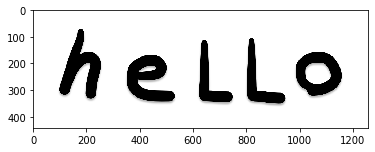

5


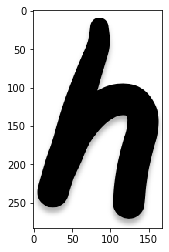

37.82 % -  H
12.96 % -  K
8.33 % -  T
6.47 % -  M
5.7 % -  V


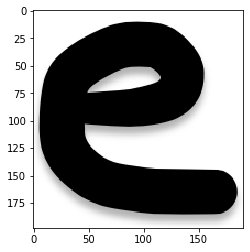

29.21 % -  E
11.84 % -  P
11.6 % -  Z
10.64 % -  C
9.59 % -  Q


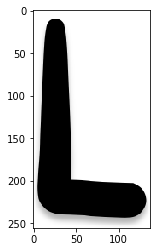

27.89 % -  L
17.25 % -  C
10.64 % -  K
9.92 % -  Z
7.46 % -  T


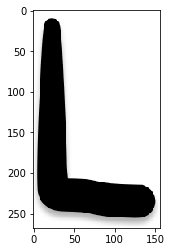

26.12 % -  L
18.48 % -  C
9.43 % -  Z
7.45 % -  K
6.28 % -  T


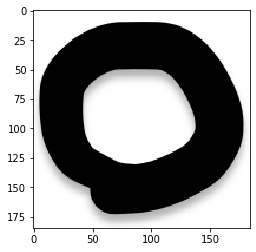

18.52 % -  O
12.81 % -  C
9.76 % -  Q
6.98 % -  G
5.96 % -  A
Actual Word:  HELLO
Word predicted:  HELLO 
---------------------------------------------------------------------------------------------------


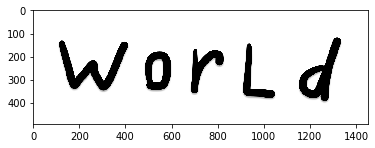

5


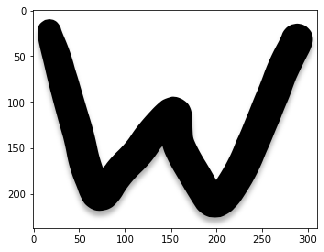

46.71 % -  W
18.79 % -  H
8.45 % -  1
5.11 % -  I
4.6 % -  V


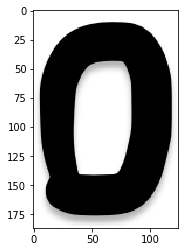

13.19 % -  O
11.76 % -  C
10.06 % -  G
7.71 % -  U
6.94 % -  Q


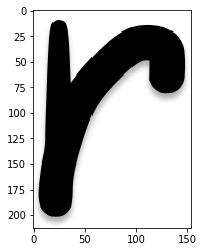

23.38 % -  R
21.65 % -  P
12.57 % -  F
8.28 % -  V
6.84 % -  Y


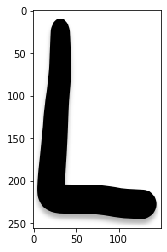

30.03 % -  L
18.98 % -  C
7.43 % -  K
7.37 % -  U
5.19 % -  Z


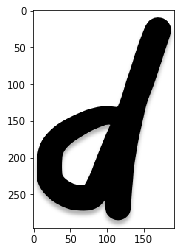

39.71 % -  D
28.76 % -  J
6.57 % -  2
6.44 % -  T
3.09 % -  6
Actual Word:  WORLD
Word predicted:  WORLD 
---------------------------------------------------------------------------------------------------


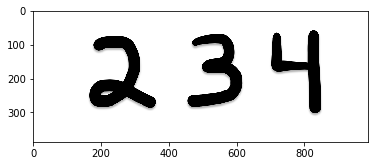

3


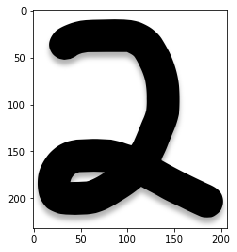

36.05 % -  2
21.13 % -  Z
11.53 % -  J
7.85 % -  D
4.28 % -  T


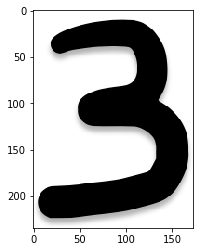

42.46 % -  3
25.71 % -  J
6.11 % -  Z
4.42 % -  Y
2.86 % -  S


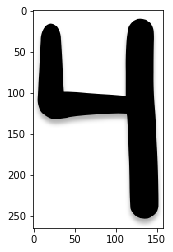

28.49 % -  4
25.01 % -  F
20.07 % -  T
7.84 % -  5
4.29 % -  9
Actual Word:  234
Word predicted:  234 
---------------------------------------------------------------------------------------------------


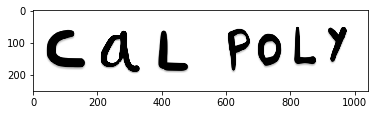

3
4


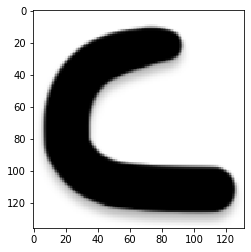

30.87 % -  C
13.97 % -  Z
7.2 % -  K
7.18 % -  T
4.36 % -  L


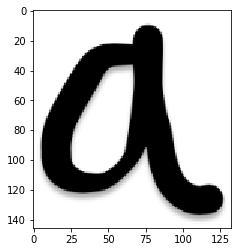

25.82 % -  A
11.44 % -  U
11.11 % -  Q
10.21 % -  2
9.9 % -  G


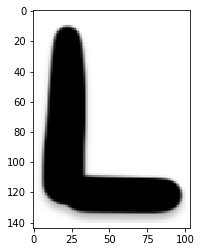

31.22 % -  L
13.46 % -  C
13.19 % -  K
10.02 % -  Z
6.91 % -  T


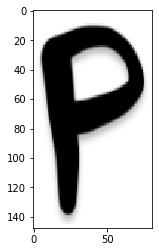

56.08 % -  P
29.36 % -  F
2.21 % -  R
2.15 % -  V
1.73 % -  9


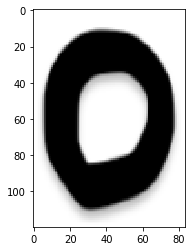

25.78 % -  O
11.61 % -  C
10.05 % -  Q
6.84 % -  E
6.51 % -  P


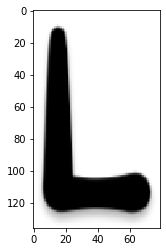

33.78 % -  L
16.12 % -  C
10.66 % -  K
10.06 % -  Z
7.42 % -  T


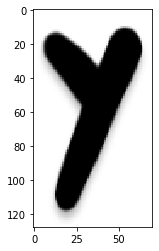

25.55 % -  Y
17.96 % -  J
14.87 % -  7
7.94 % -  P
7.61 % -  X
Actual Word:  CAL POLY
Word predicted:  CAL POLY 
---------------------------------------------------------------------------------------------------


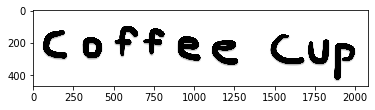

6
3


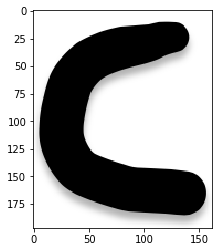

34.25 % -  C
9.21 % -  Z
7.51 % -  5
7.07 % -  F
5.19 % -  L


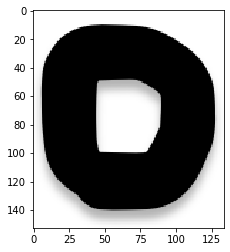

12.91 % -  O
10.55 % -  P
9.47 % -  G
7.84 % -  Q
5.92 % -  C


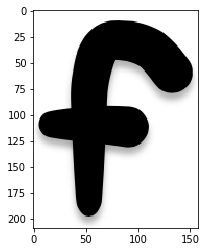

53.94 % -  F
25.44 % -  T
7.24 % -  J
3.58 % -  4
1.4 % -  S


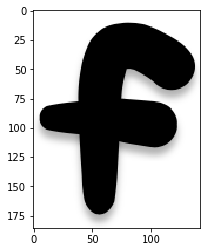

42.02 % -  F
17.0 % -  T
13.86 % -  J
8.88 % -  4
2.25 % -  X


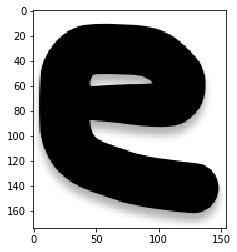

19.9 % -  E
12.48 % -  P
12.14 % -  Q
10.93 % -  Z
7.98 % -  F


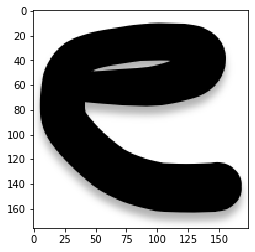

17.59 % -  E
13.53 % -  C
12.22 % -  P
11.44 % -  F
8.45 % -  Z


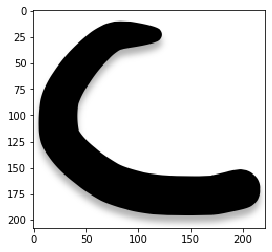

36.64 % -  C
22.52 % -  L
6.25 % -  6
5.1 % -  Z
4.44 % -  K


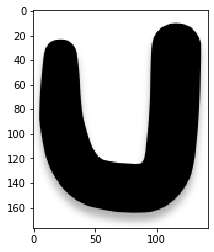

15.54 % -  U
14.32 % -  V
11.3 % -  L
9.47 % -  J
6.07 % -  B


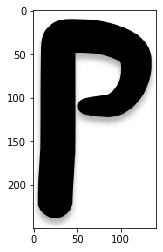

44.75 % -  P
25.41 % -  F
3.79 % -  R
3.48 % -  9
3.11 % -  E
Actual Word:  COFFEE CUP
Word predicted:  COFFEE CUP 
---------------------------------------------------------------------------------------------------


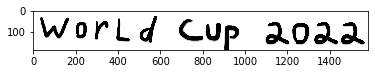

5
3
4


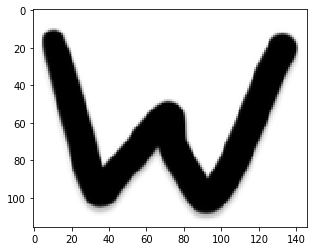

56.52 % -  W
14.07 % -  H
6.31 % -  V
4.82 % -  1
4.67 % -  U


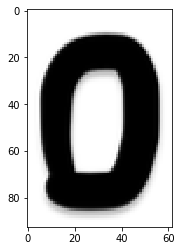

22.44 % -  O
10.18 % -  C
9.54 % -  G
8.29 % -  A
8.16 % -  Q


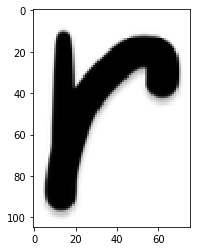

30.22 % -  R
27.92 % -  P
12.27 % -  F
6.18 % -  Y
5.17 % -  V


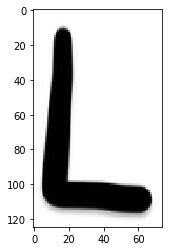

35.14 % -  L
17.33 % -  C
7.55 % -  K
7.48 % -  Z
5.55 % -  T


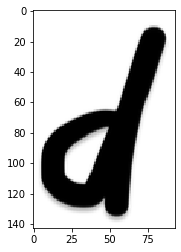

46.36 % -  D
31.17 % -  J
5.2 % -  2
3.42 % -  T
2.36 % -  6


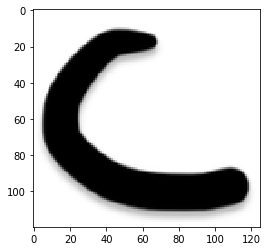

44.77 % -  C
15.18 % -  L
8.3 % -  Z
4.9 % -  6
4.06 % -  K


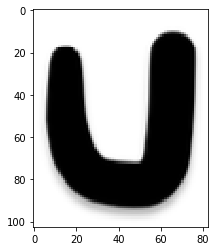

19.97 % -  U
19.22 % -  V
10.83 % -  J
5.85 % -  4
5.71 % -  W


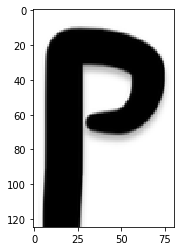

45.24 % -  P
25.2 % -  F
5.53 % -  9
4.72 % -  E
2.79 % -  G


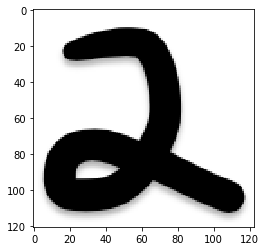

45.91 % -  2
19.38 % -  Z
11.96 % -  D
5.87 % -  J
2.6 % -  X


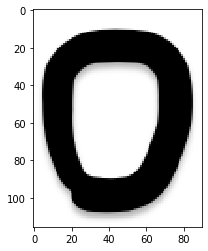

24.2 % -  O
14.94 % -  C
8.51 % -  G
8.06 % -  J
7.4 % -  Q


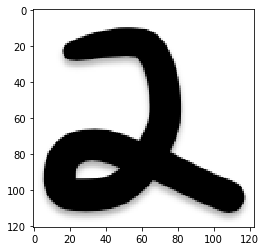

45.91 % -  2
19.38 % -  Z
11.96 % -  D
5.87 % -  J
2.6 % -  X


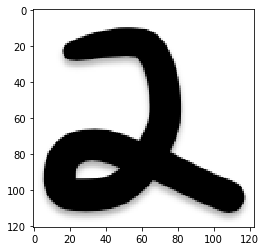

45.91 % -  2
19.38 % -  Z
11.96 % -  D
5.87 % -  J
2.6 % -  X
Actual Word:  WORLD CUP 2022
Word predicted:  WORLD CUP 2O22 
---------------------------------------------------------------------------------------------------


In [0]:
if __name__ == "__main__":

  actual_word = ["HELLO","WORLD","234","CAL POLY", "COFFEE CUP", "WORLD CUP 2022"]
  image_name = ["word_test1.jpg","word_test2.jpg","word_test3.jpg","phrase_test1.jpg", "phrase_test2.jpg","phrase_test3.jpg"]

  for j in range(len(image_name)):
      img = cv2.imread(IMG_PATH + image_name[j])
      image_array = getCharImages(img)

      #Display input image
      plt.imshow(img) 
      plt.show()

      word_length = getWordImages(image_name[j])

      new_image_array = []
      predicted_word = ""

      for i in range(len(image_array)):
        plt.imshow(image_array[i][:,:]) 
        plt.show()

        new_image_array = (process_image(image_array[i]))
        pred_distribution, prediction = get_prediction(new_image_array)

        predicted_word = predicted_word + prediction
        get_probability(pred_distribution)

      new_string = ""
      start = 0
      for k in word_length:
        new_string += predicted_word[start:start+k] + " " 

        start+=k

      print("Actual Word: ", actual_word[j])
      print("Word predicted: ", new_string)

      print("---------------------------------------------------------------------------------------------------")

